In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [201]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [24]:
# import essential packages
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.lines import Line2D

In [25]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])
    
def plot_graph(G,H):
    #nodes position information
    pos = pd.read_pickle('../data/US_air_geo_information.pkl')

    #prepare labels for edges
    labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
    colors = ['black', 'red']
    styles = ['solid', 'dashed']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

    #select snapshot for displaying 
    year = date(2014,1,1)
    G.remove_nodes_from(['payson_az','hanapepe_hi'])

    #edges separation
    ## the edges that are in mainland us
    edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
    edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


    #plot
    border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
    # sizey = 8
    # sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
    sizex = stdfigsize(ratio=-1)[0]
    sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
    fig = plt.figure(figsize=(xs,ys))

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    shp = shapereader.Reader(states_shp)
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    for record, state in zip(shp.records(), shp.geometries()):
        name = record.attributes['name']
        facecolor = '#f0f0f0'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor='none',zorder=-1)
    ax.set_extent(border, crs=ccrs.PlateCarree())

    #draw edges
    nx.draw(G,
            pos = pos,
            width= 0.1,
            alpha= 0.2,
            node_size = 0,
            edgelist= edges_in_land,
            edge_color = 'black',
            style = 'solid')

    #draw nodes
    nx.draw(G,
            pos = pos,
            node_color = '#377eb8',
            width= 0,
            alpha= 1,
            node_size = np.array(list(dict(H.degree()).values()))/2)
    
    nx.draw(G,
        pos = pos,
        node_color = 'grey',               
        alpha= 1,
        edgelist = [],
        labels = dict([(node,make_node_name(node)) for node in G.nodes]),
        node_size = 0,
        font_color = 'black')
    
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    #plt.title('Data')
    plt.tight_layout()
    #plt.savefig('../figures/Fig.1_US_Domestic_Flights_Network_v2.png',bbox_inches='tight',dpi=500,transparent=True)
    plt.show()

In [ ]:
node = 'chicago_il'
for G in graphs_decay[0::10]:
    plot_graph(nx.from_edgelist([(node,v) for v in G.neighbors(node)],create_using=nx.Graph()),G)
    fig,ax = plt.subplots()
    plt.hist([d for n,d in G.degree()])
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

    fig,ax = plt.subplots()
    plt.hist(nx.eigenvector_centrality_numpy(G).values())
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

In [6]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [212]:
import glob, os

df = pd.DataFrame()#{'time':[],'Nedges':[],'Gcc':[]})
N = graphs_air[-1].number_of_nodes()

for f in glob.glob('../simulation1/results/*.pickle.dat'):
    graphs_prediction = pickle.load(open(f,'rb'))
    df_temp = pd.DataFrame({})
    if len(graphs_prediction) < 200:
        start_index = -1
        df_temp['start'] = ['ending'] *len(graphs_prediction)
    else:
        start_index = 0
        df_temp['start'] = ['begining'] *len(graphs_prediction)
    df_temp['time'] = [add_months(date_air[start_index],j) for j in range(len(graphs_prediction))]
    df_temp['Nedges'] = [G.number_of_edges() for G in graphs_prediction]
    df_temp['Gcc'] = [max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_prediction]
    df_temp['Niso'] = [len(list(nx.isolates(G))) for G in graphs_prediction]
    if 'null' in f:
        df_temp['graph'] = ['null'] *len(graphs_prediction)
    else:
        df_temp['graph'] = ['model'] *len(graphs_prediction)
    df_temp['Nr'] = [f.strip('.pickle.dat').split('_')[-2].strip('Nr')] *len(graphs_prediction)
    df_temp['Na'] = [f.strip('.pickle.dat').split('_')[-1][2:-1]] *len(graphs_prediction)
    df = df.append(df_temp)

In [179]:
df.start.unique()

array(['ending', 'begining'], dtype=object)

In [206]:
#data  = df[df.Na =='1300']
#data = data[data.graph =='model']
data = df#[df.graph=='model']
data = data[data.start=='ending']
data['Nr'] = data.Nr.astype(int)

In [207]:
data.head()

,start,time,Nedges,Gcc,Niso,graph,Nr,Na
0,ending,2018-12-01,6016,0.389085,1204,null,1302,1300
1,ending,2019-01-01,6014,0.771097,336,null,1302,1300
2,ending,2019-02-01,6012,0.931784,120,null,1302,1300
3,ending,2019-03-01,6010,0.968671,57,null,1302,1300
4,ending,2019-04-01,6008,0.985851,28,null,1302,1300


In [371]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit([[i] for i in range(len(graphs_air))], [G.number_of_edges() for G in graphs_air])

In [372]:
reg.coef_

array([-5.7848529])

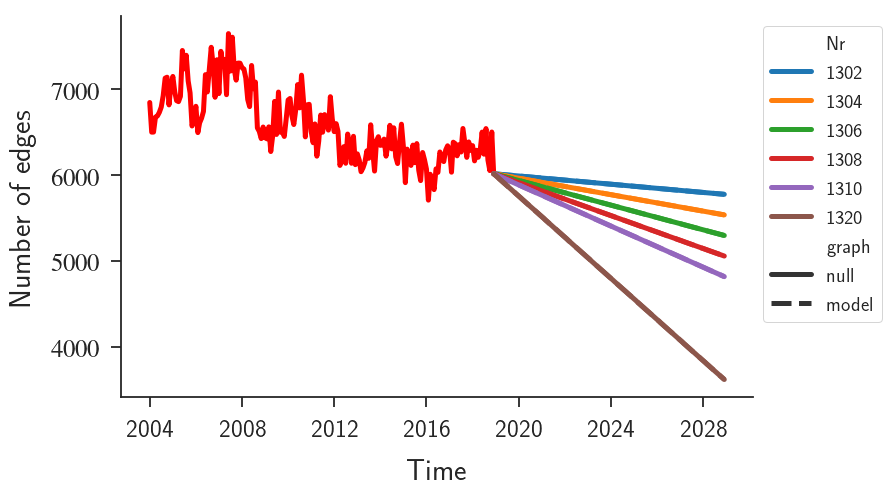

In [235]:
colors = sns.color_palette(None, 6)#['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Nedges",hue='Nr', style='graph',palette=colors, legend = 'full', data=data[data.Nr>=1302])
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

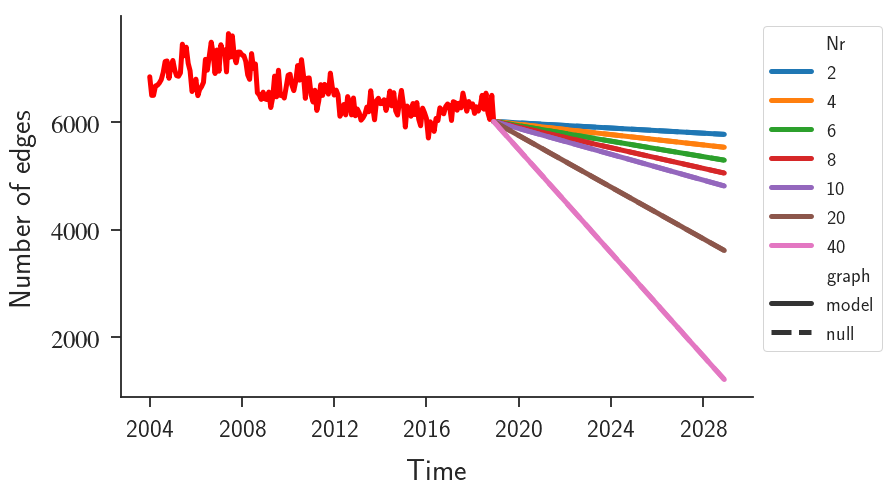

In [284]:
colors = sns.color_palette(None, 7)#['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Nedges",hue='Nr', style='graph',palette=colors, legend = 'full', data=data[data.Nr<100])
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

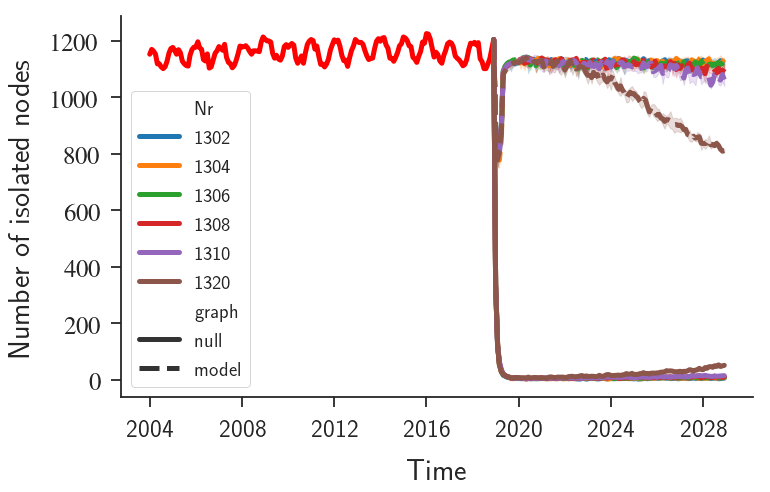

In [228]:
colors = sns.color_palette(None, 6)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[len(list(nx.isolates(G))) for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Niso",hue='Nr',style='graph',palette=colors, legend = 'full', data=data[data.Nr>=1302])
plt.xlabel('Time')
plt.ylabel("Number of isolated nodes")
custom_frame(ax)
plt.show()

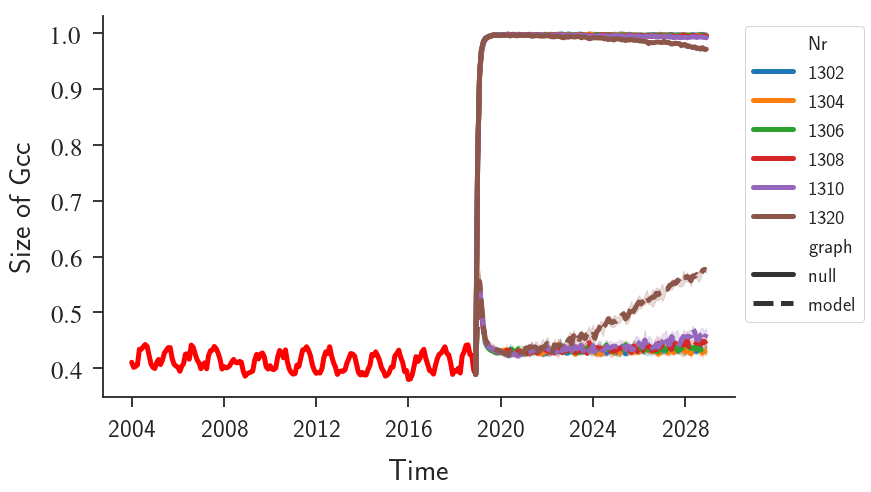

In [236]:
colors = sns.color_palette(None, 6)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr>=1302])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

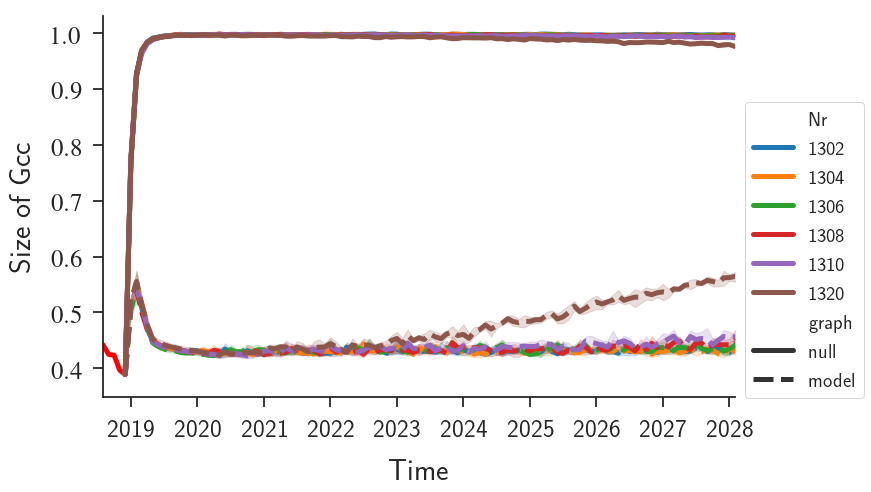

In [242]:
colors = sns.color_palette(None, 6)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr>=1302])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.xlim(date(2018,8,1),date(2028,2,1))
plt.legend(bbox_to_anchor=(1.0, 0.8))
custom_frame(ax)
plt.show()

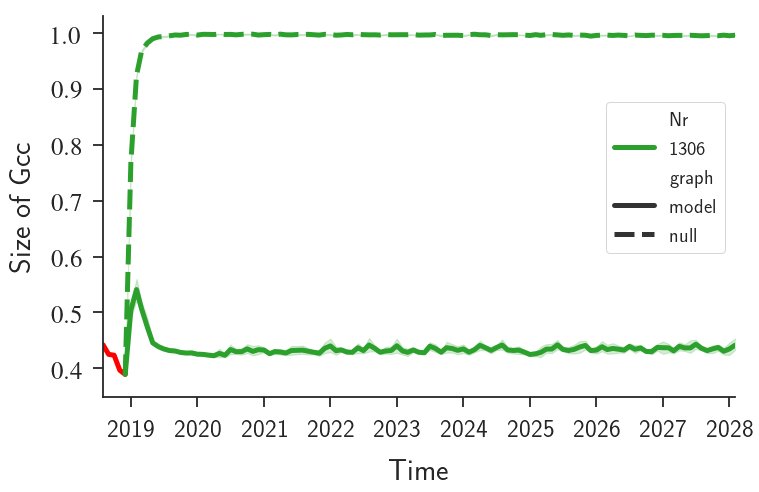

In [245]:
colors = sns.color_palette(None, 6)[2:3]
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr==1306])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.xlim(date(2018,8,1),date(2028,2,1))
plt.legend(bbox_to_anchor=(1.0, 0.8))
custom_frame(ax)
plt.show()

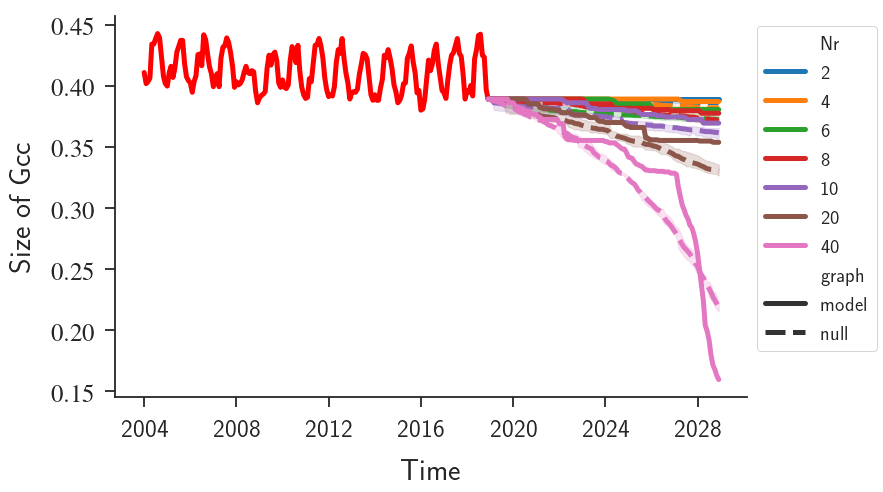

In [238]:
colors = sns.color_palette(None, 7)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr<=1000])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

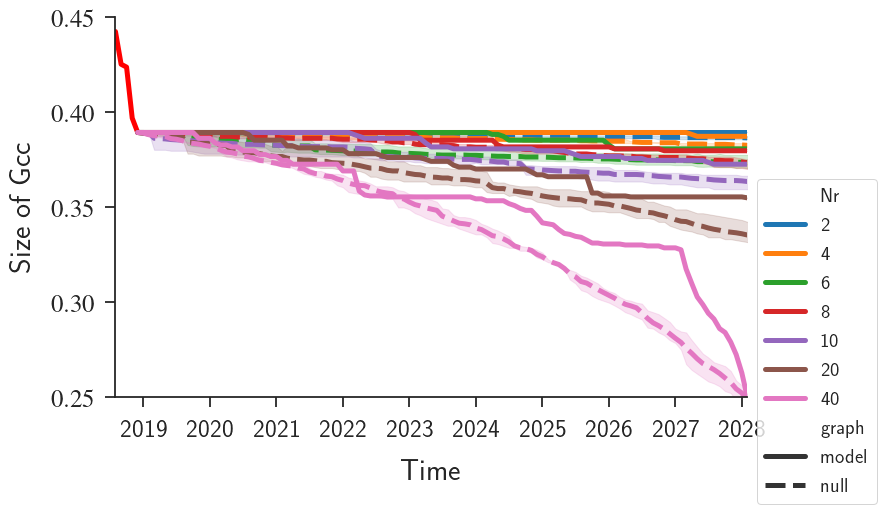

In [250]:
colors = sns.color_palette(None, 7)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr<=1000])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.xlim(date(2018,8,1),date(2028,2,1))
plt.legend(bbox_to_anchor=(1.0, 0.6))
plt.ylim(0.25,0.45)
custom_frame(ax)
plt.show()

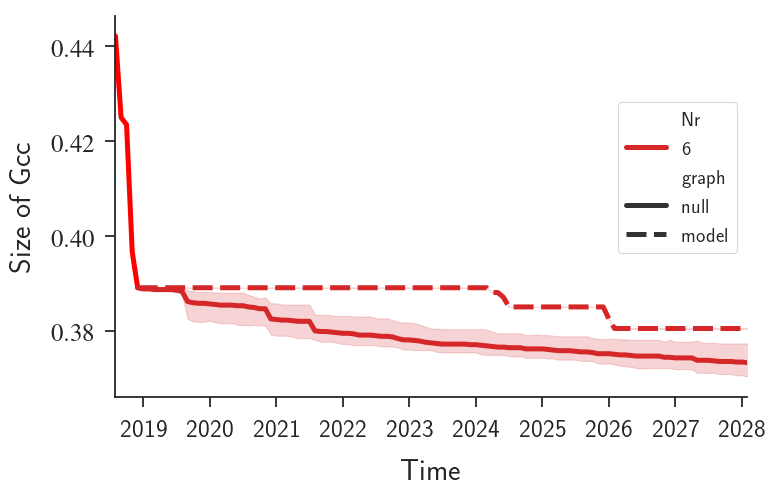

In [255]:
colors = sns.color_palette(None, 7)[3:4]
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,style='graph',legend = 'full',data=data[data.Nr==6])
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.xlim(date(2018,8,1),date(2028,2,1))
plt.legend(bbox_to_anchor=(1.0, 0.8))
custom_frame(ax)
plt.show()

In [ ]:
for f in glob.glob('../simulation1/results/*.pickle.dat'):
    G = pickle.load(open(f,'rb'))[0]
    if f.strip('.pickle.dat').split('_')[-2].strip('Nr') == '6':
        centrality = nx.eigenvector_centrality(G)
        sorted_centrality = sorted([(c,v) for v,c in centrality.items()],reverse=True)
        fig,ax=plt.subplots(figsize=(5,5))
        x = [make_node_name(v) for c,v in sorted_centrality[0:10] ]
        y = [c for c,v in sorted_centrality[0:10] ]
        plt.barh(x, y, align='center')
        plt.xticks(rotation=90)
        custom_frame(ax)
        plt.show() 

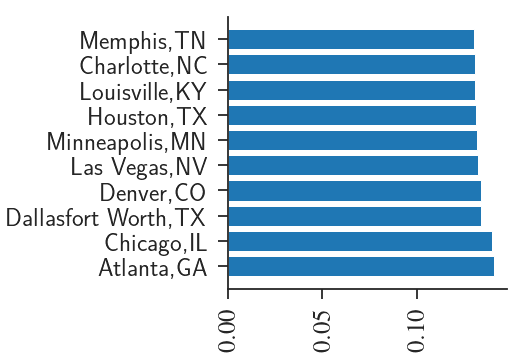

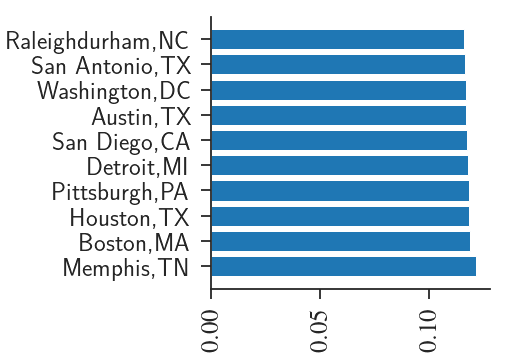

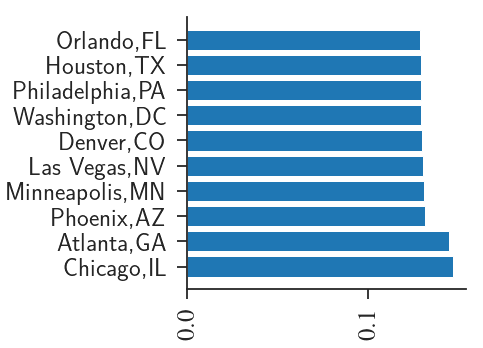

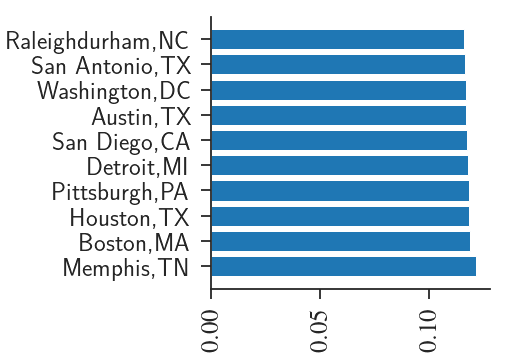

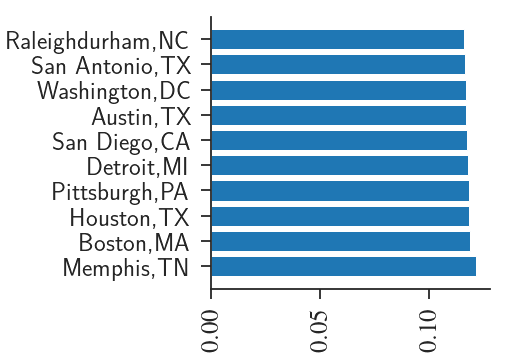

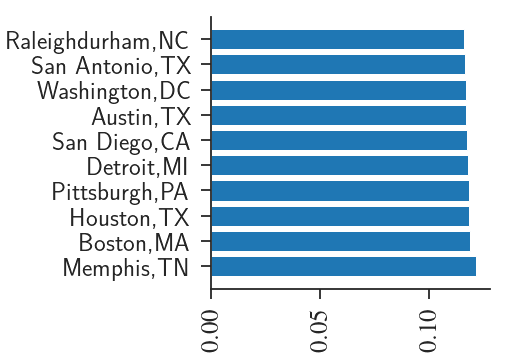

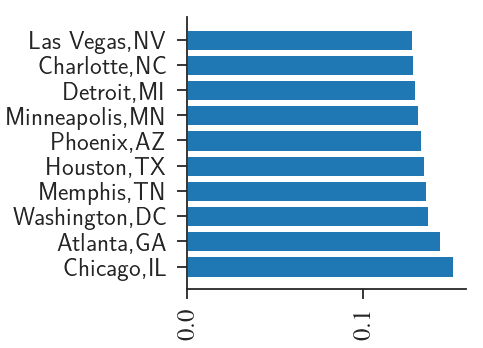

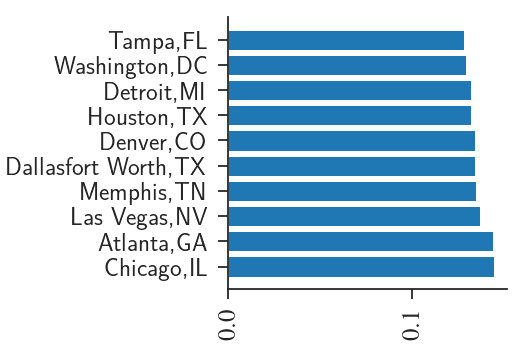

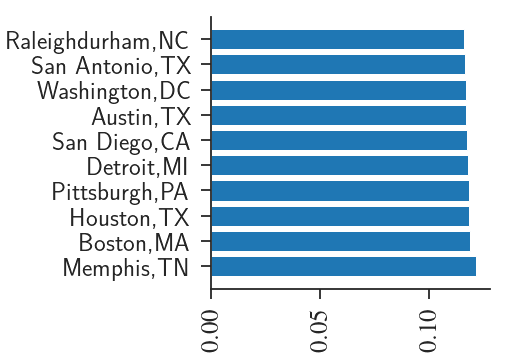

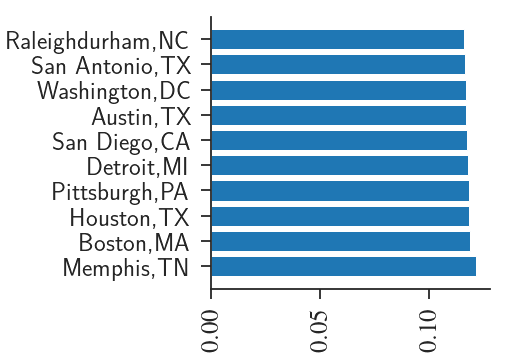

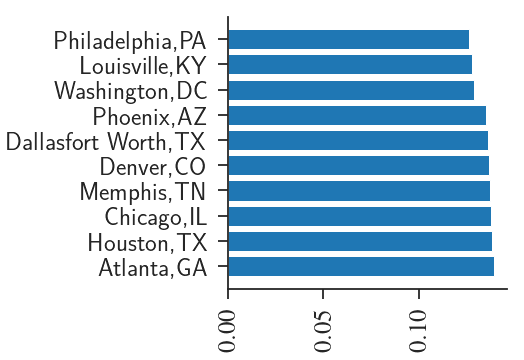

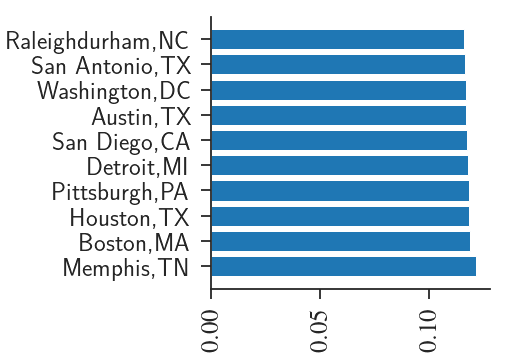

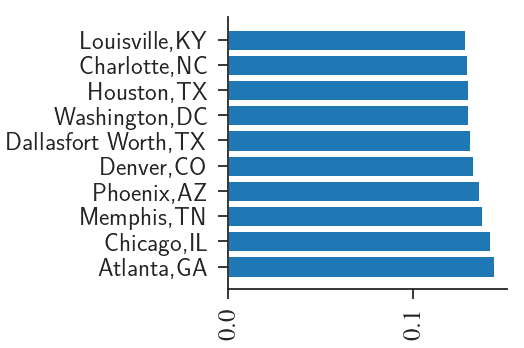

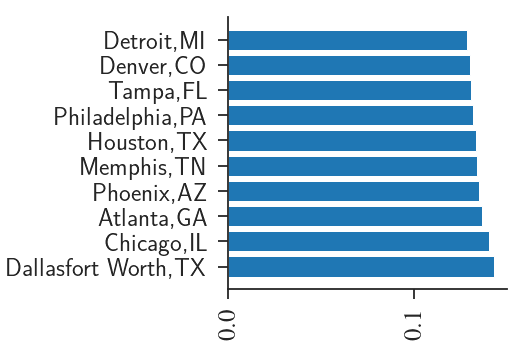

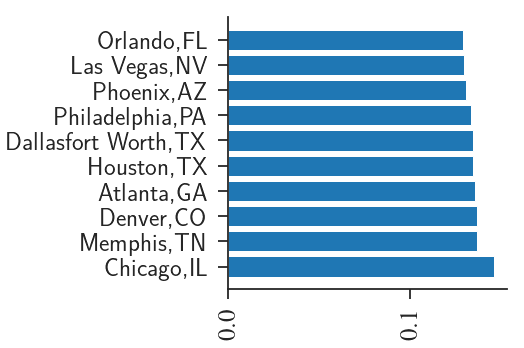

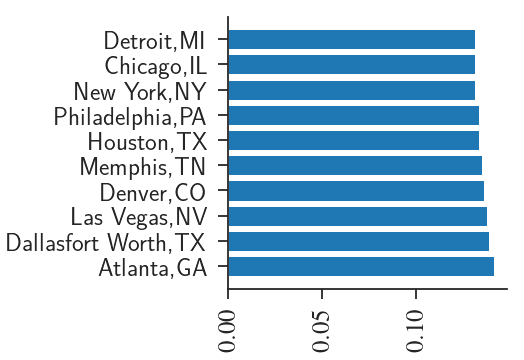

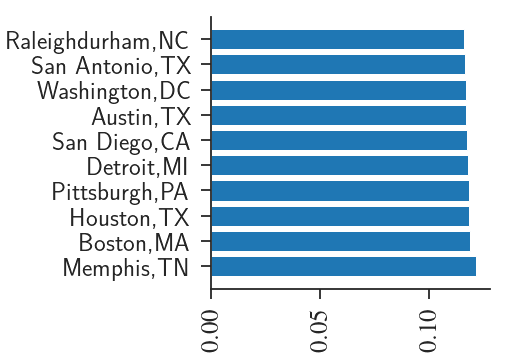

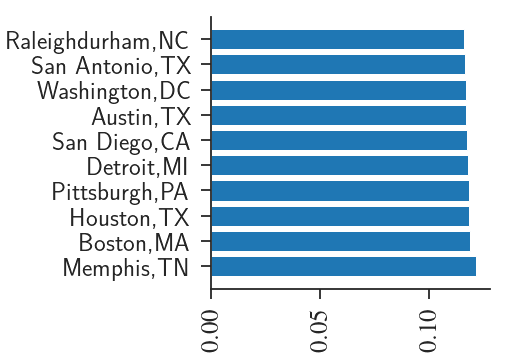

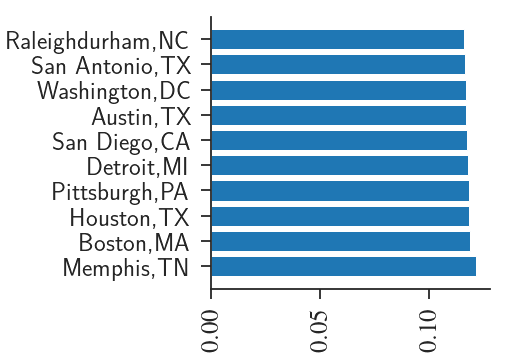

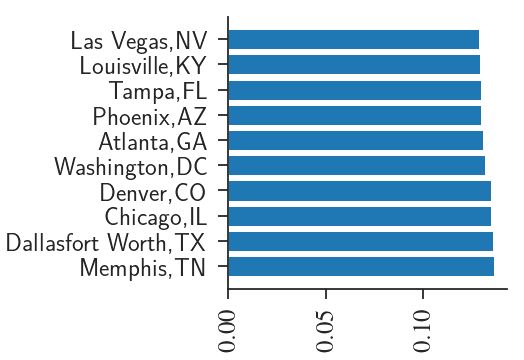

In [269]:
for f in glob.glob('../simulation1/results/*.pickle.dat'):
    G = pickle.load(open(f,'rb'))[-1]
    if f.strip('.pickle.dat').split('_')[-2].strip('Nr') == '6':
        centrality = nx.eigenvector_centrality(G)
        sorted_centrality = sorted([(c,v) for v,c in centrality.items()],reverse=True)
        fig,ax=plt.subplots(figsize=(5,5))
        x = [make_node_name(v) for c,v in sorted_centrality[0:10] ]
        y = [c for c,v in sorted_centrality[0:10] ]
        plt.barh(x, y, align='center')
        plt.xticks(rotation=90)
        custom_frame(ax)
        plt.show() 

In [ ]:
node = 'chicago_il'
for G in graphs_decay[0::10]:
    plot_graph(nx.from_edgelist([(node,v) for v in G.neighbors(node)],create_using=nx.Graph()),G)
    fig,ax = plt.subplots()
    plt.hist([d for n,d in G.degree()])
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

    fig,ax = plt.subplots()
    plt.hist(nx.eigenvector_centrality_numpy(G).values())
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

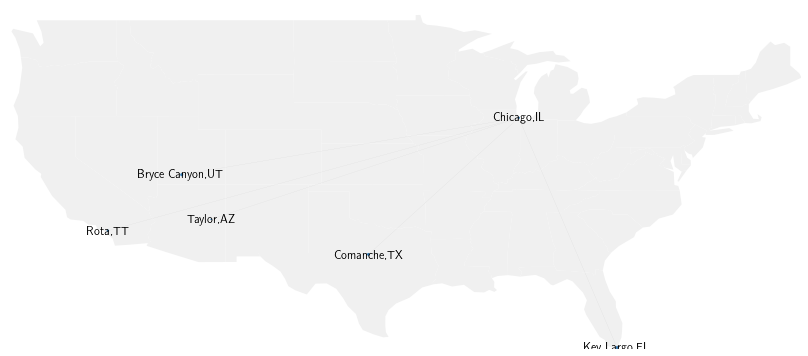

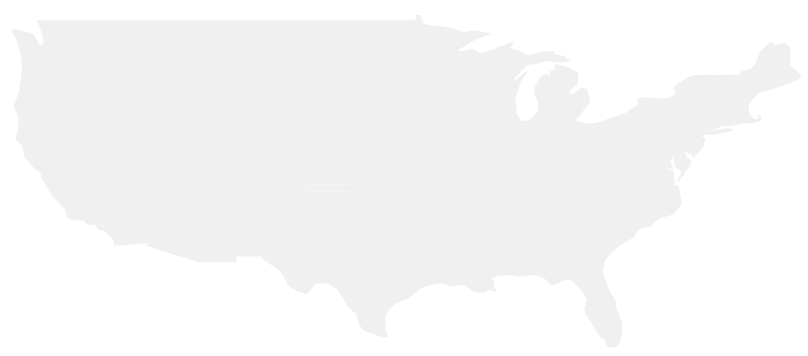

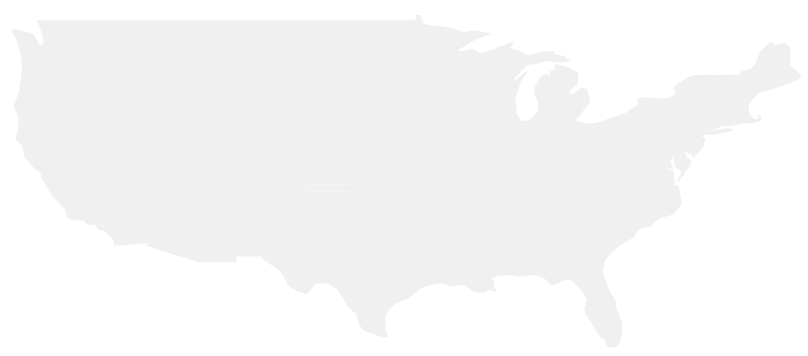

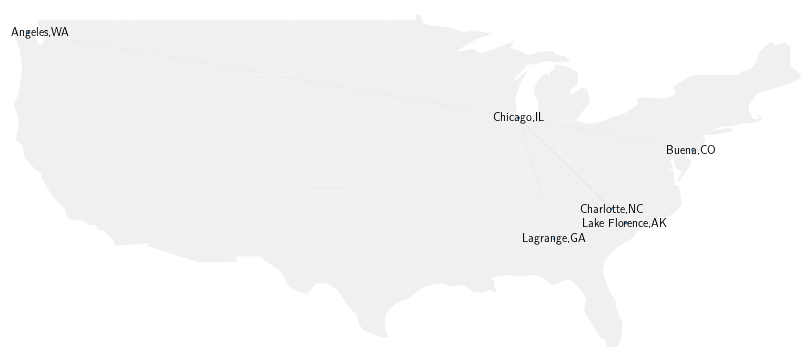

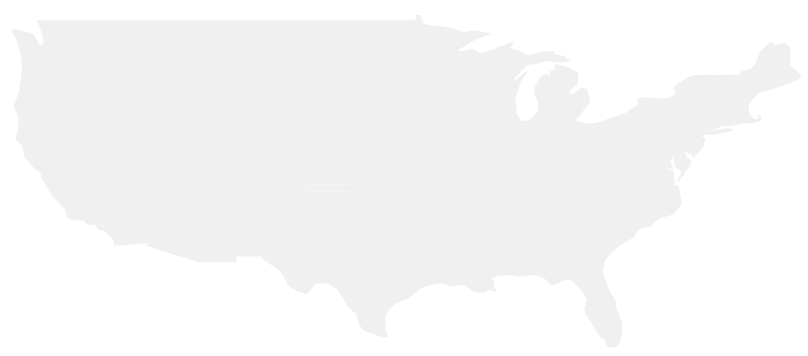

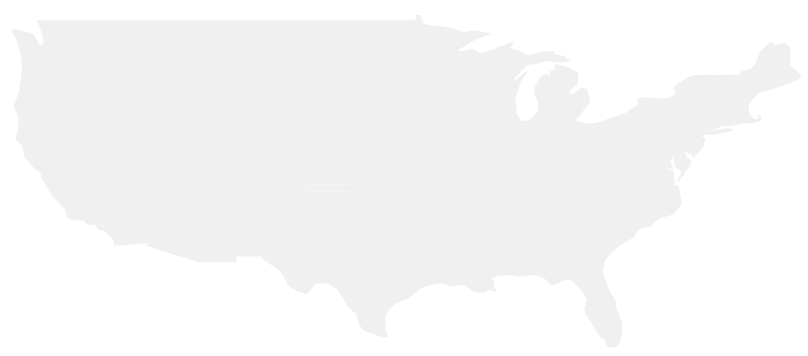

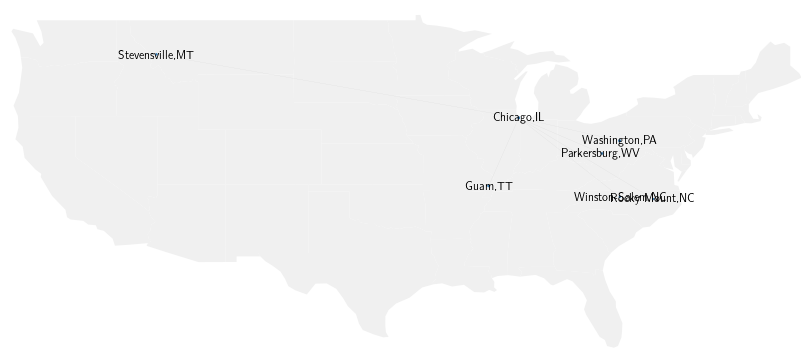

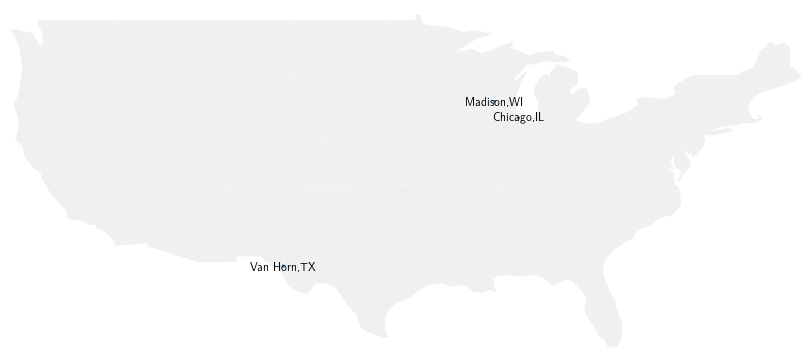

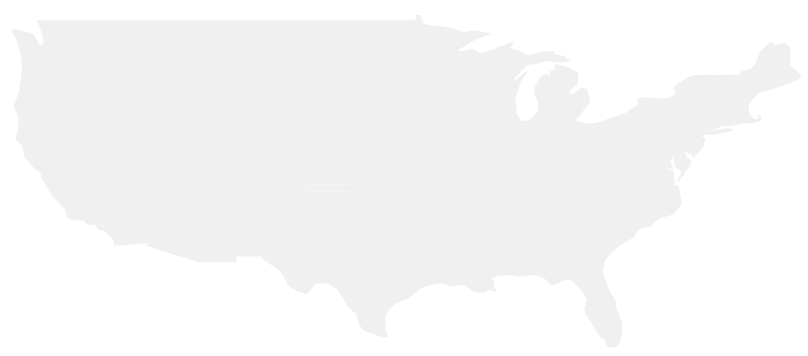

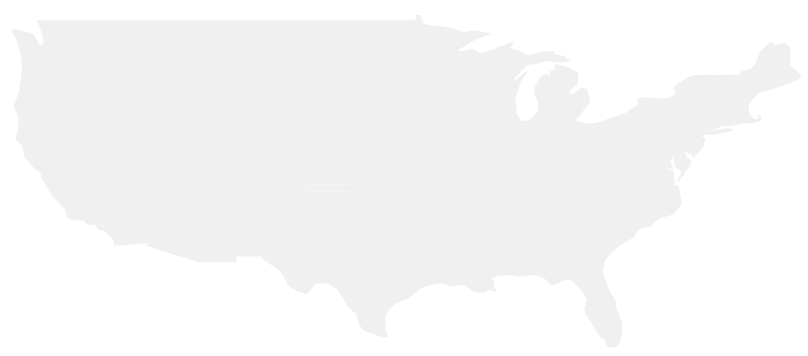

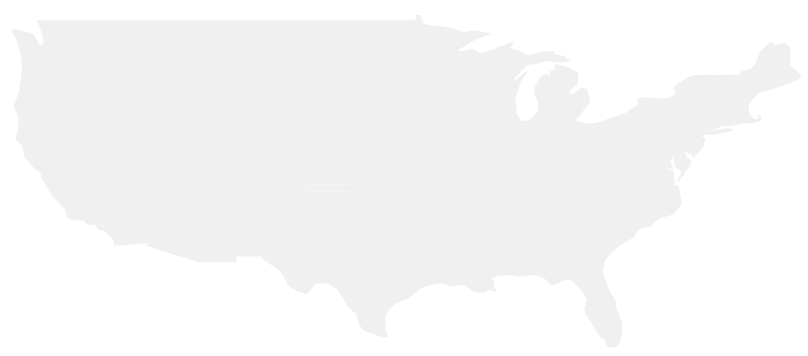

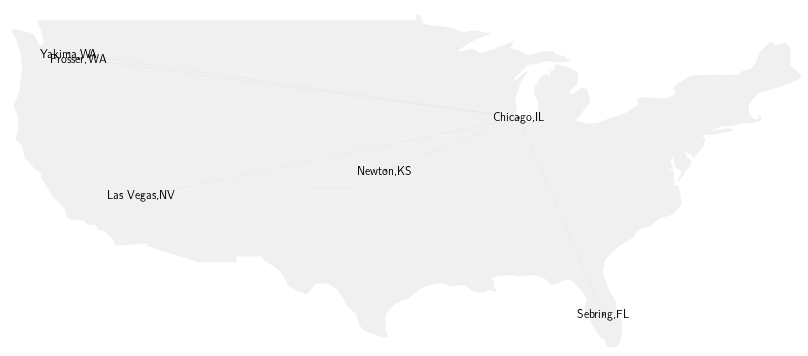

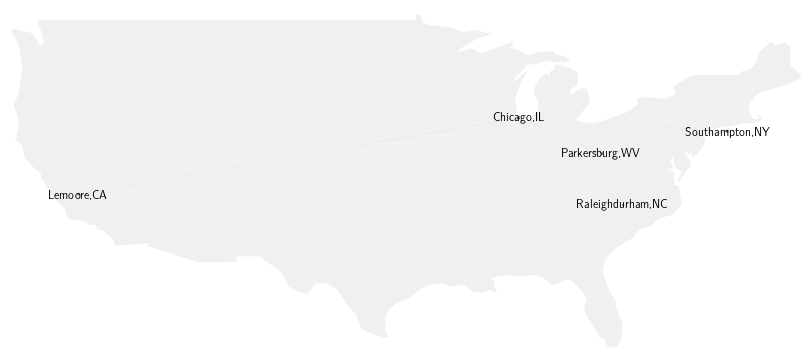

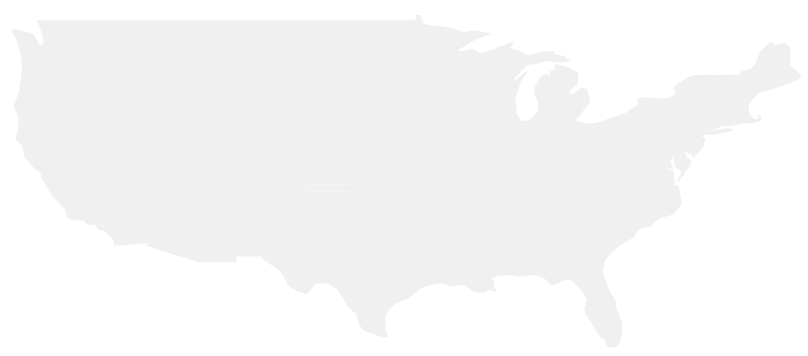

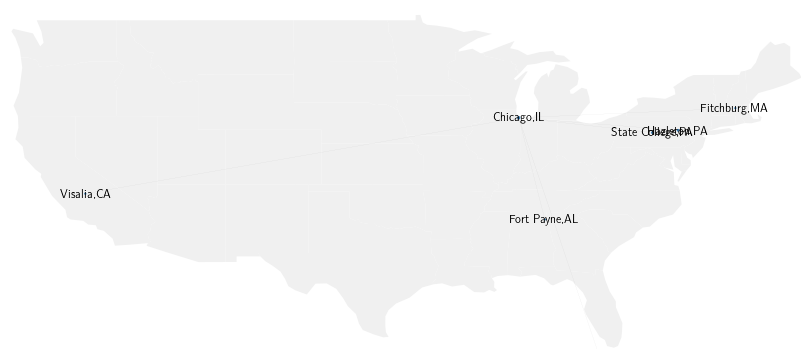

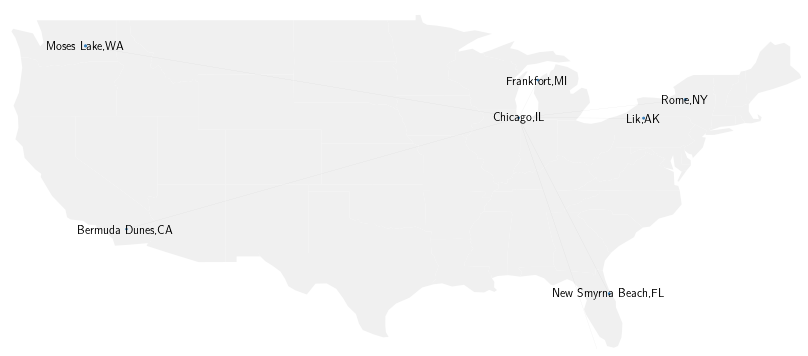

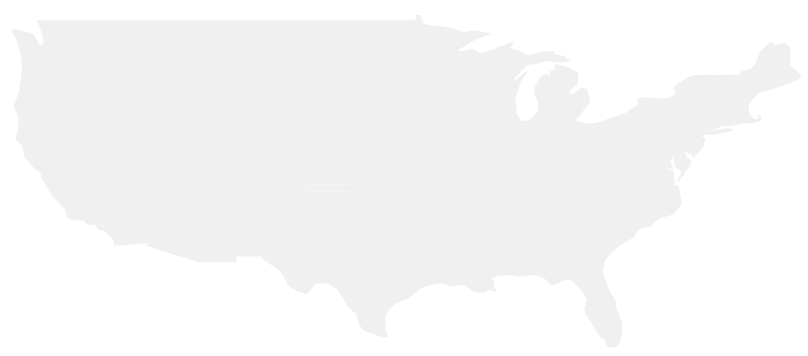

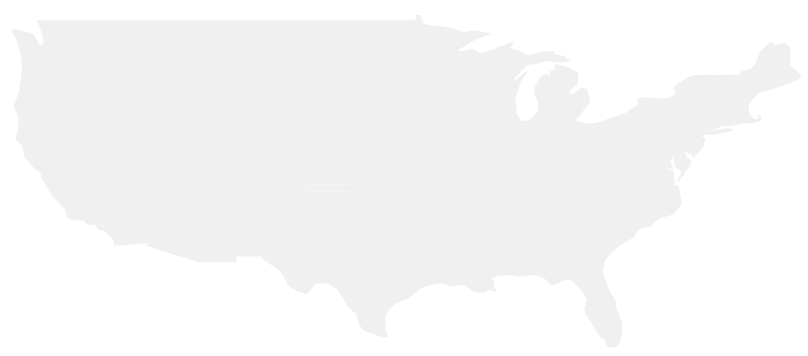

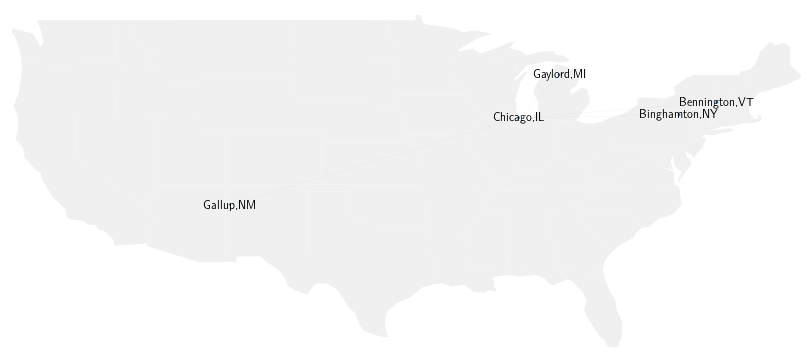

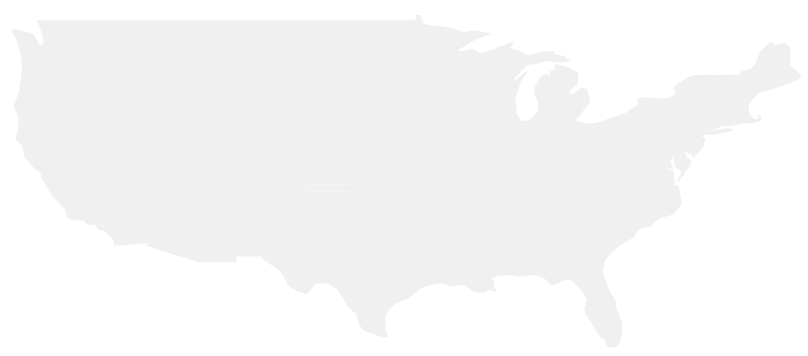

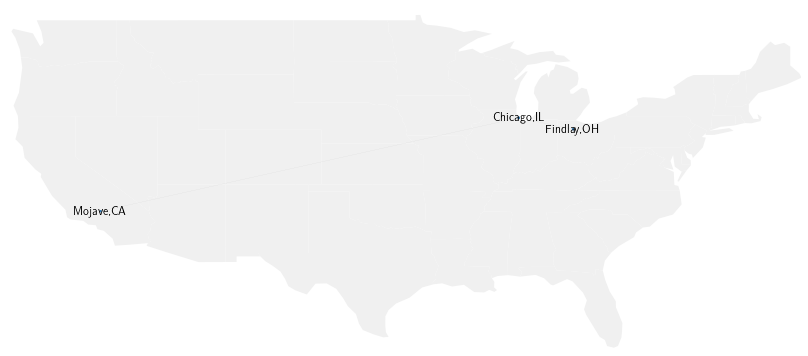

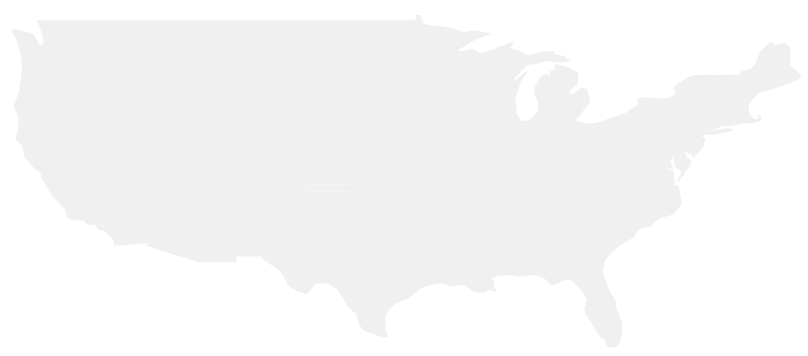

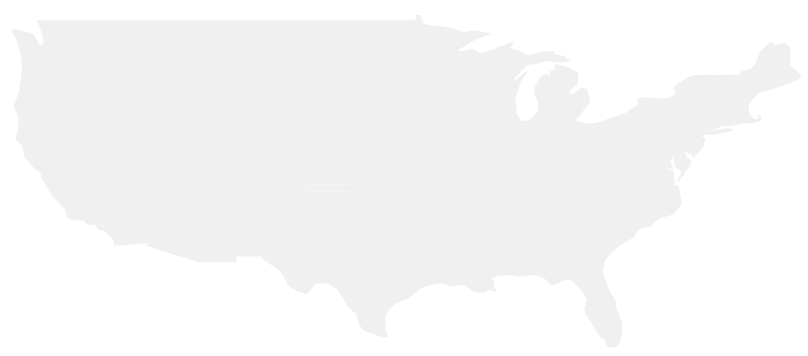

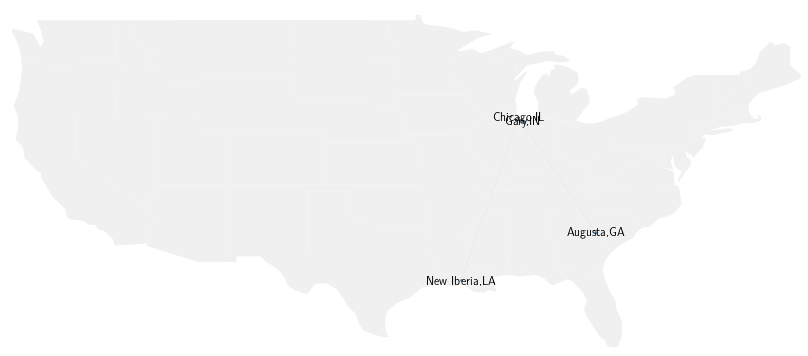

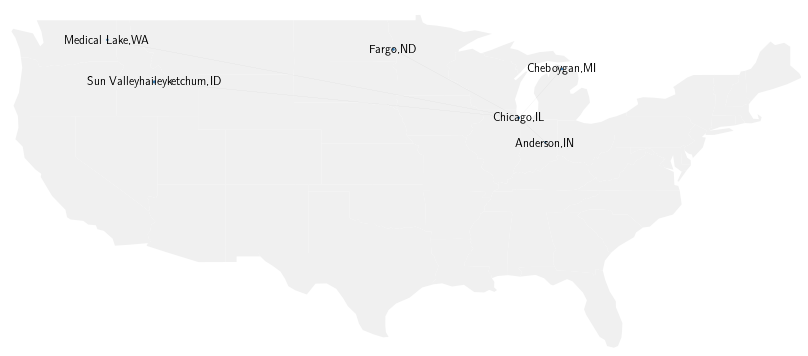

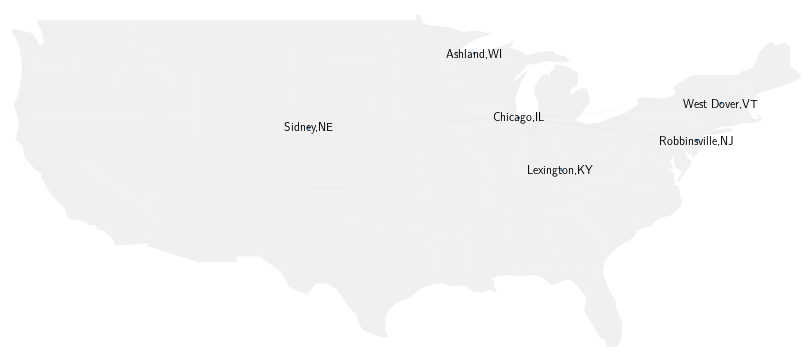

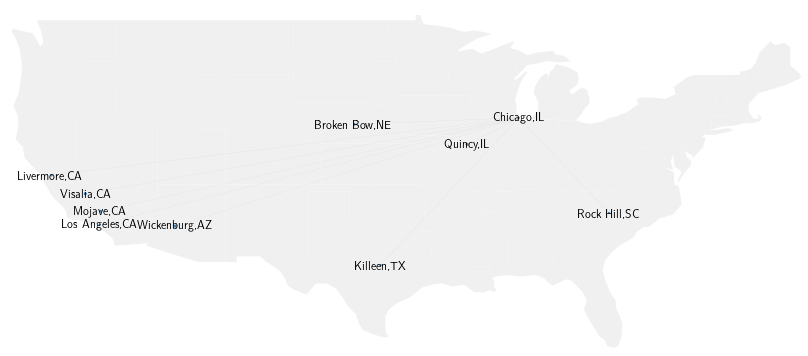

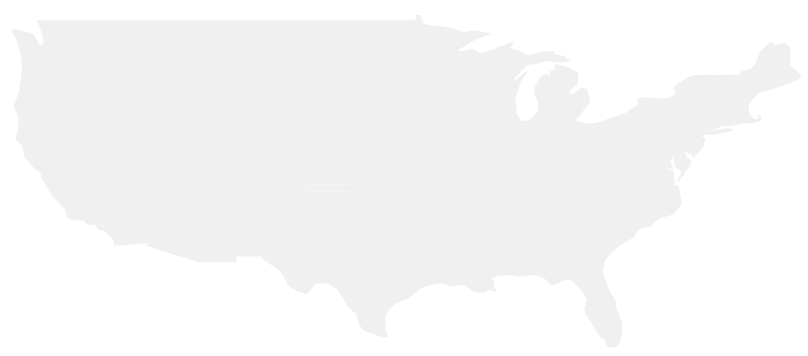

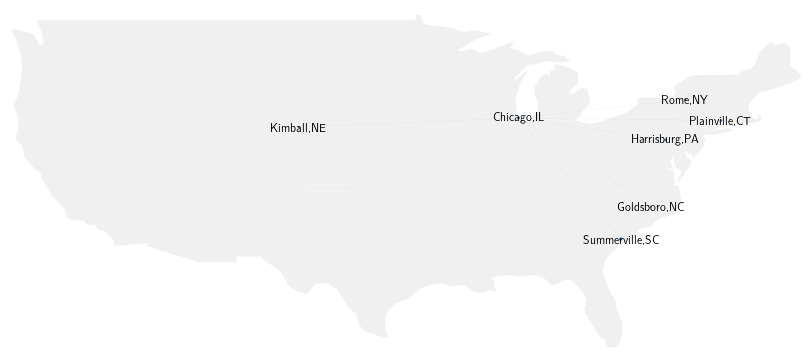

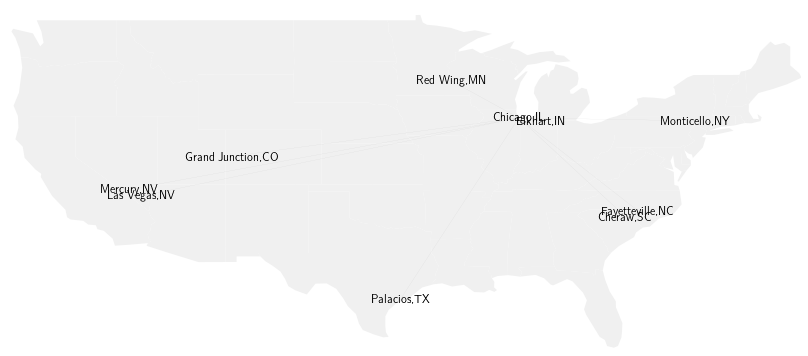

In [254]:
node = 'chicago_il'
for f in glob.glob('../simulation1/results/*.pickle.dat'):
    G = pickle.load(open(f,'rb'))[-1]
    if f.strip('.pickle.dat').split('_')[-2].strip('Nr') == '1306':
        plot_graph(nx.from_edgelist([(node,v) for v in G.neighbors(node)],create_using=nx.Graph()),G)

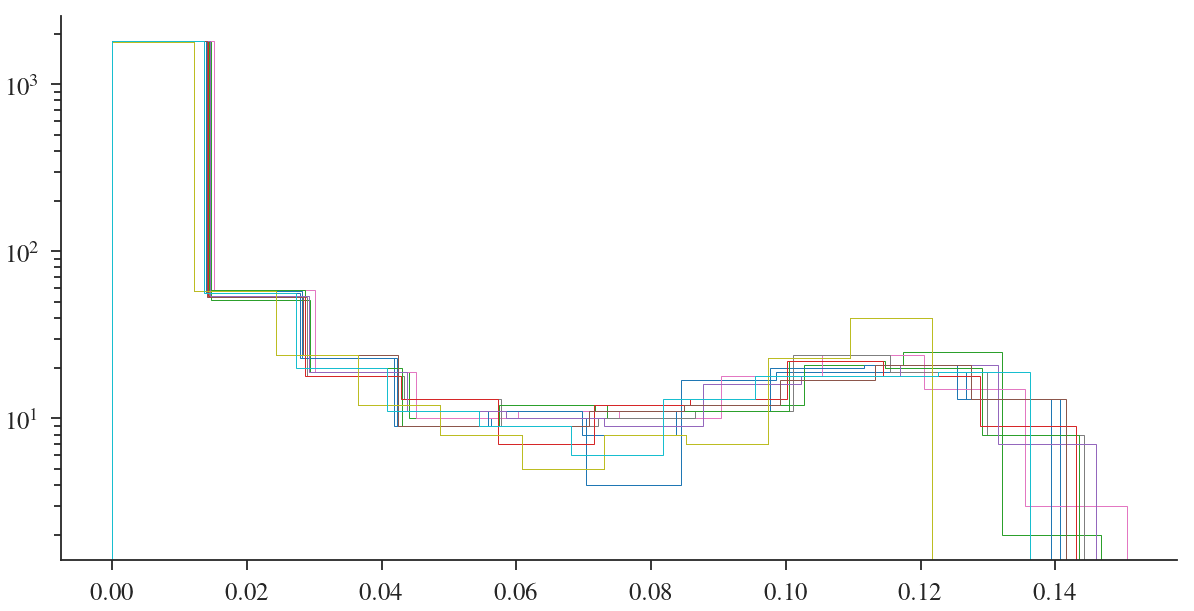

In [282]:
#cm = dict(zip(data.Nr.unique(),colors))
fig,ax=plt.subplots(figsize=(20,10))
for f in glob.glob('../simulation1/results/*.pickle.dat'):
    graphs_prediction = pickle.load(open(f,'rb'))
    label = f.strip('.pickle.dat').split('_')[-2].strip('Nr')
    if label == '6':
        plt.hist(nx.eigenvector_centrality_numpy(graphs_prediction[-1]).values(),label=label,histtype='step')
        plt.yscale('log')
        custom_frame(ax)
plt.show()

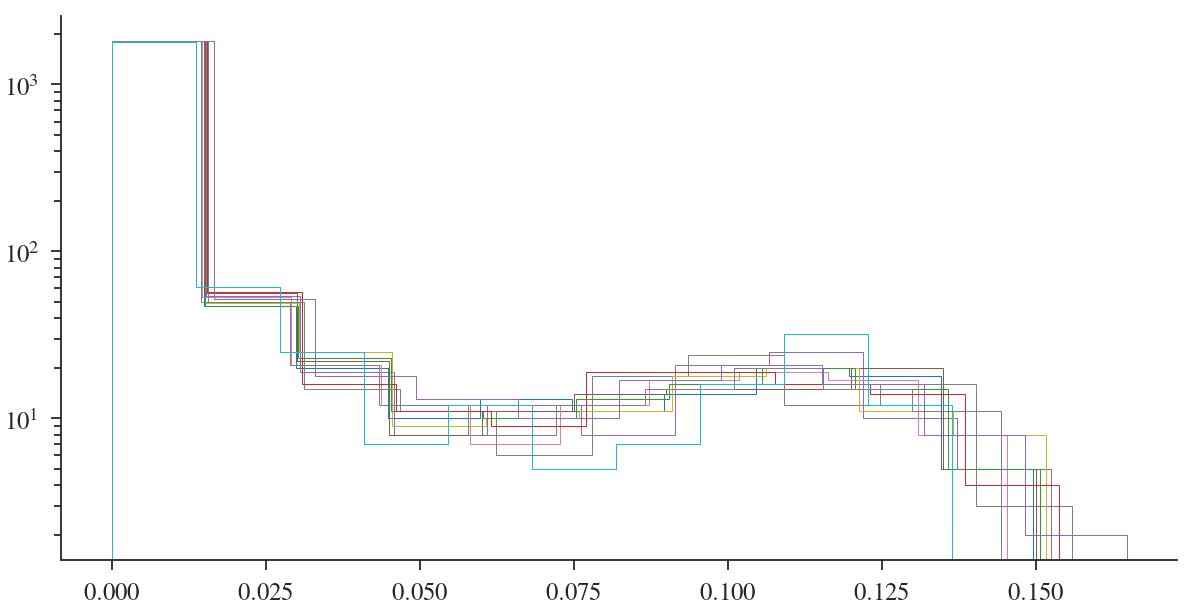

In [283]:
fig,ax=plt.subplots(figsize=(20,10))
for f in glob.glob('../simulation1/results/*.pickle.dat'):
    graphs_prediction = pickle.load(open(f,'rb'))
    label = f.strip('.pickle.dat').split('_')[-2].strip('Nr')
    if label == '20':
        plt.hist(nx.eigenvector_centrality_numpy(graphs_prediction[-1]).values(),label=label,histtype='step')
        plt.yscale('log')
        custom_frame(ax)
plt.show()

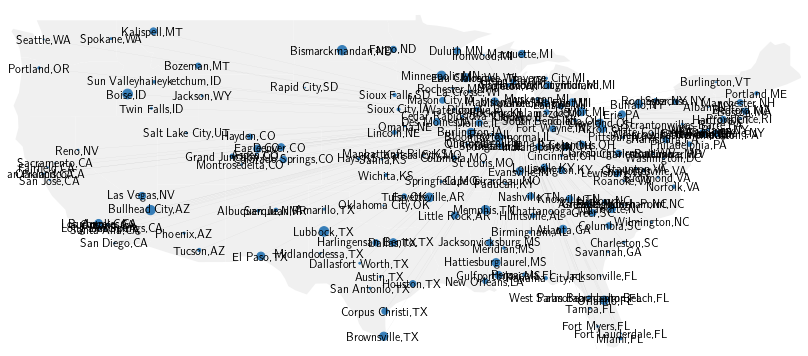

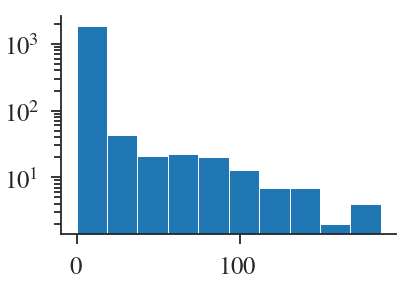

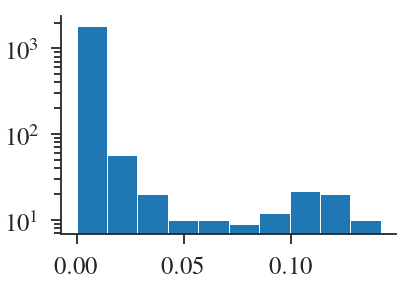

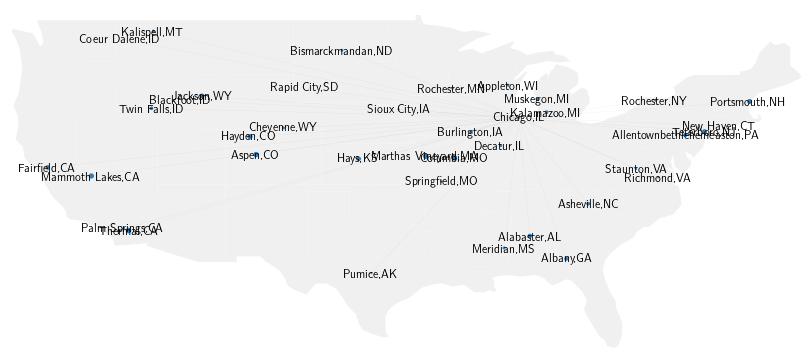

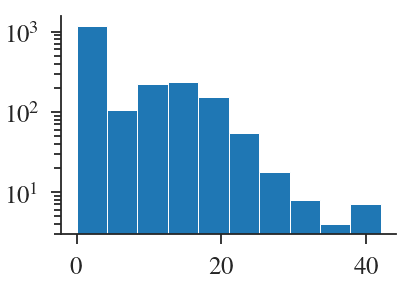

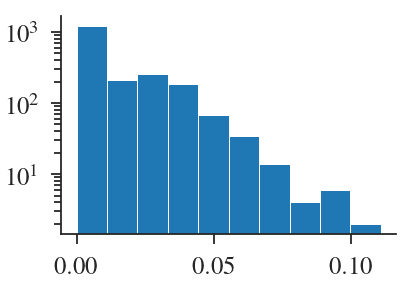

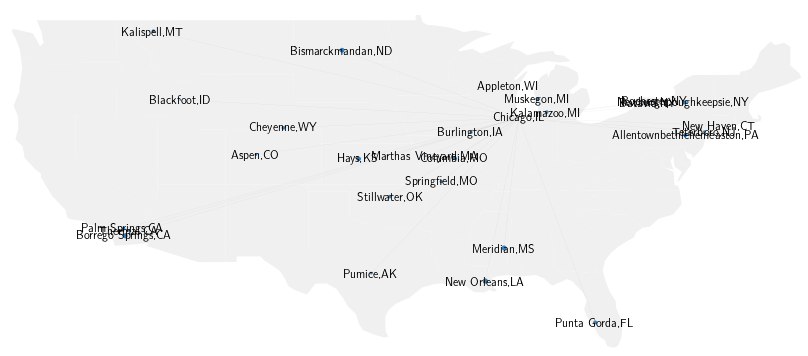

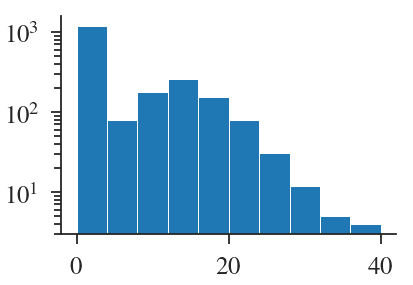

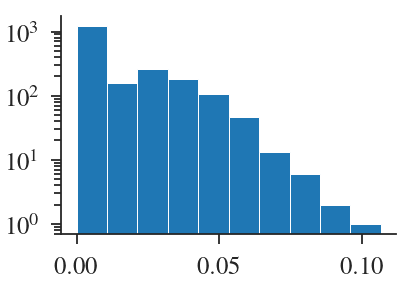

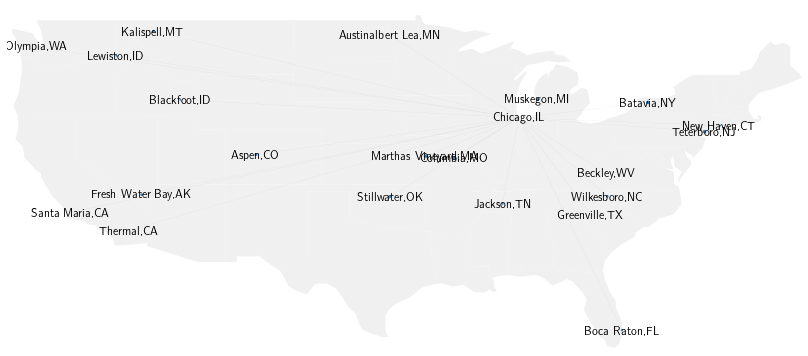

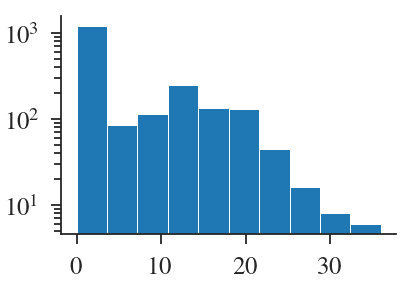

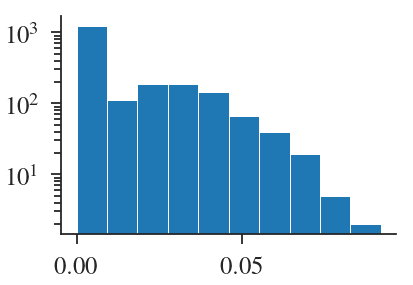

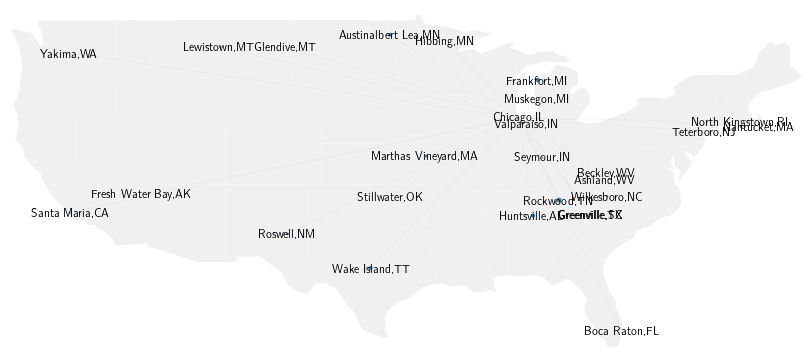

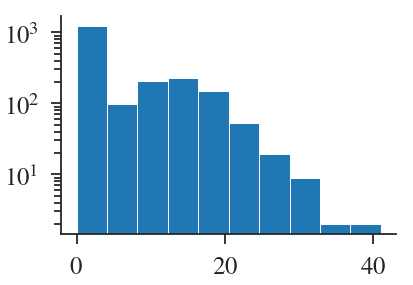

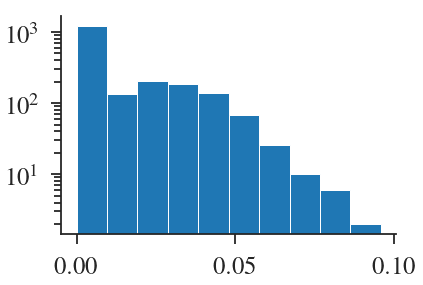

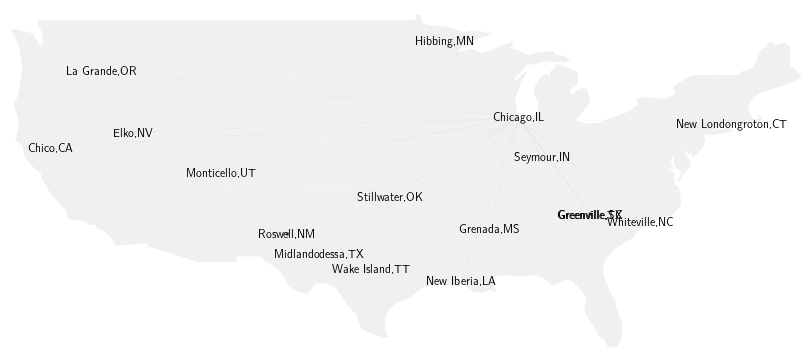

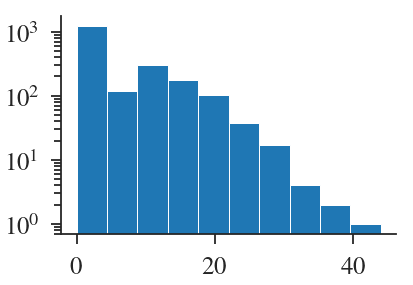

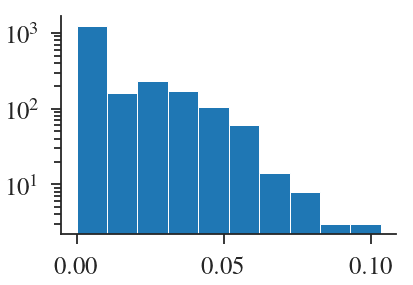

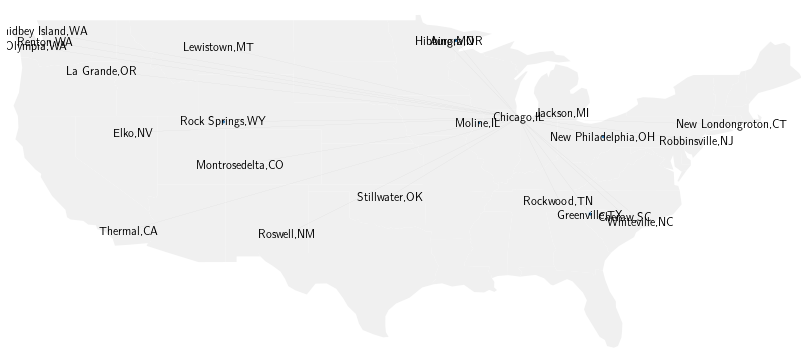

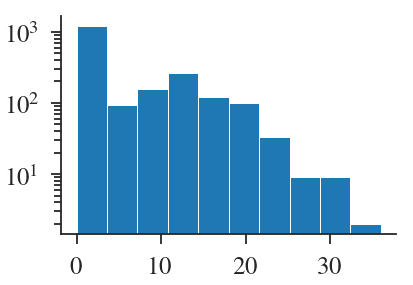

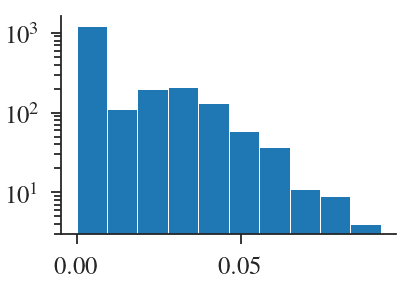

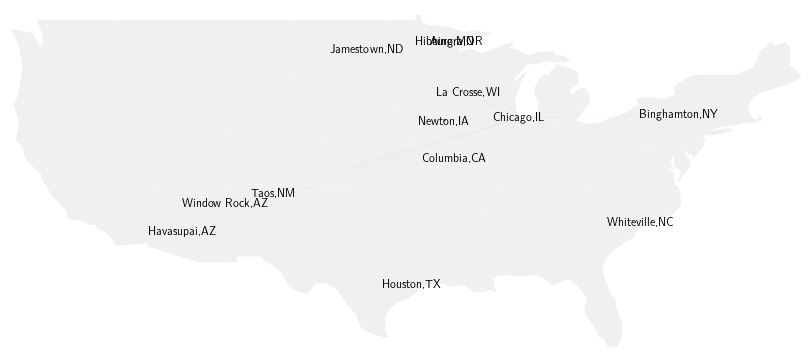

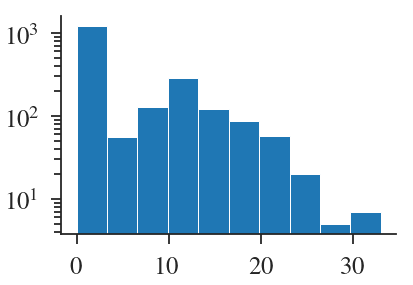

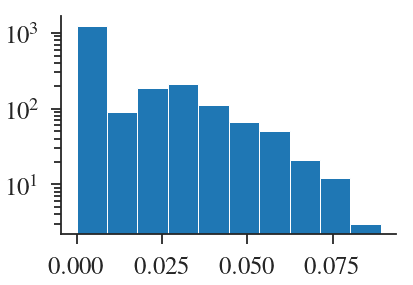

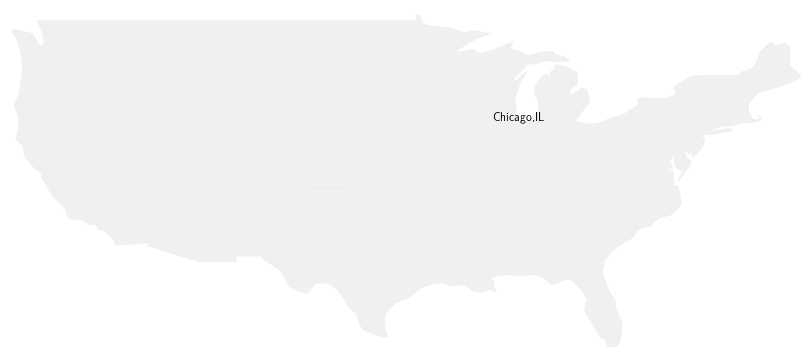

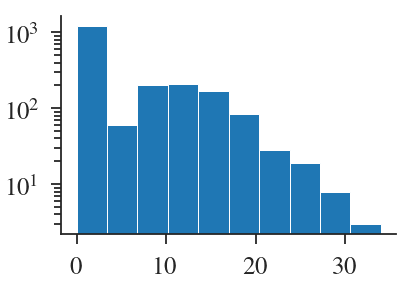

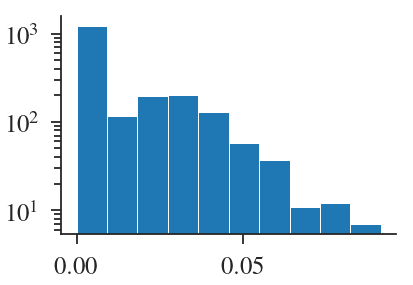

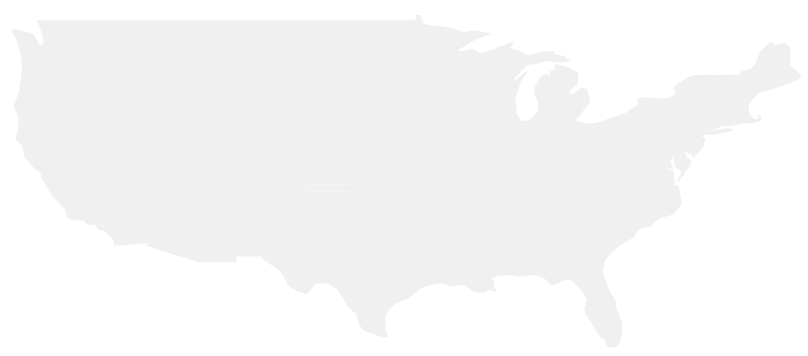

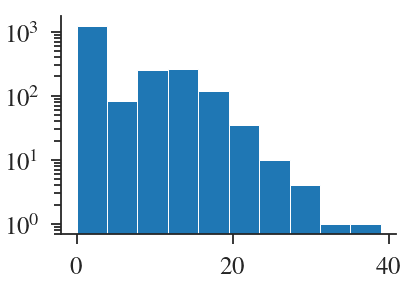

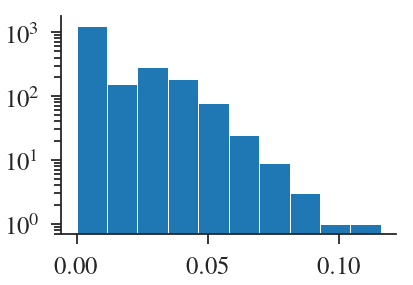

In [32]:
node = 'chicago_il'
for G in pickle.load(open('../simulation1/results/model_graphs_Nr1310_Na13000.pickle.dat','rb'))[0:120:12]:
    plot_graph(nx.from_edgelist([(node,v) for v in G.neighbors(node)],create_using=nx.Graph()),G)
    fig,ax = plt.subplots()
    plt.hist([d for n,d in G.degree()])
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

    fig,ax = plt.subplots()
    plt.hist(nx.eigenvector_centrality_numpy(G).values())
    plt.yscale('log')
    custom_frame(ax)
    plt.show()

In [61]:
from collections import Counter
affect_states = [dict(Counter([make_node_name(i)[-2::] for i in list(nx.isolates(G))])) for G in graphs_prediction]

In [75]:
states = sorted(list(set([make_node_name(i)[-2::] for i in graphs_air[0].nodes()])))

In [98]:
affect = np.array([[np.log10(D[s]) if s in D.keys() else 0 for s in states ] for D in affect_states]).T

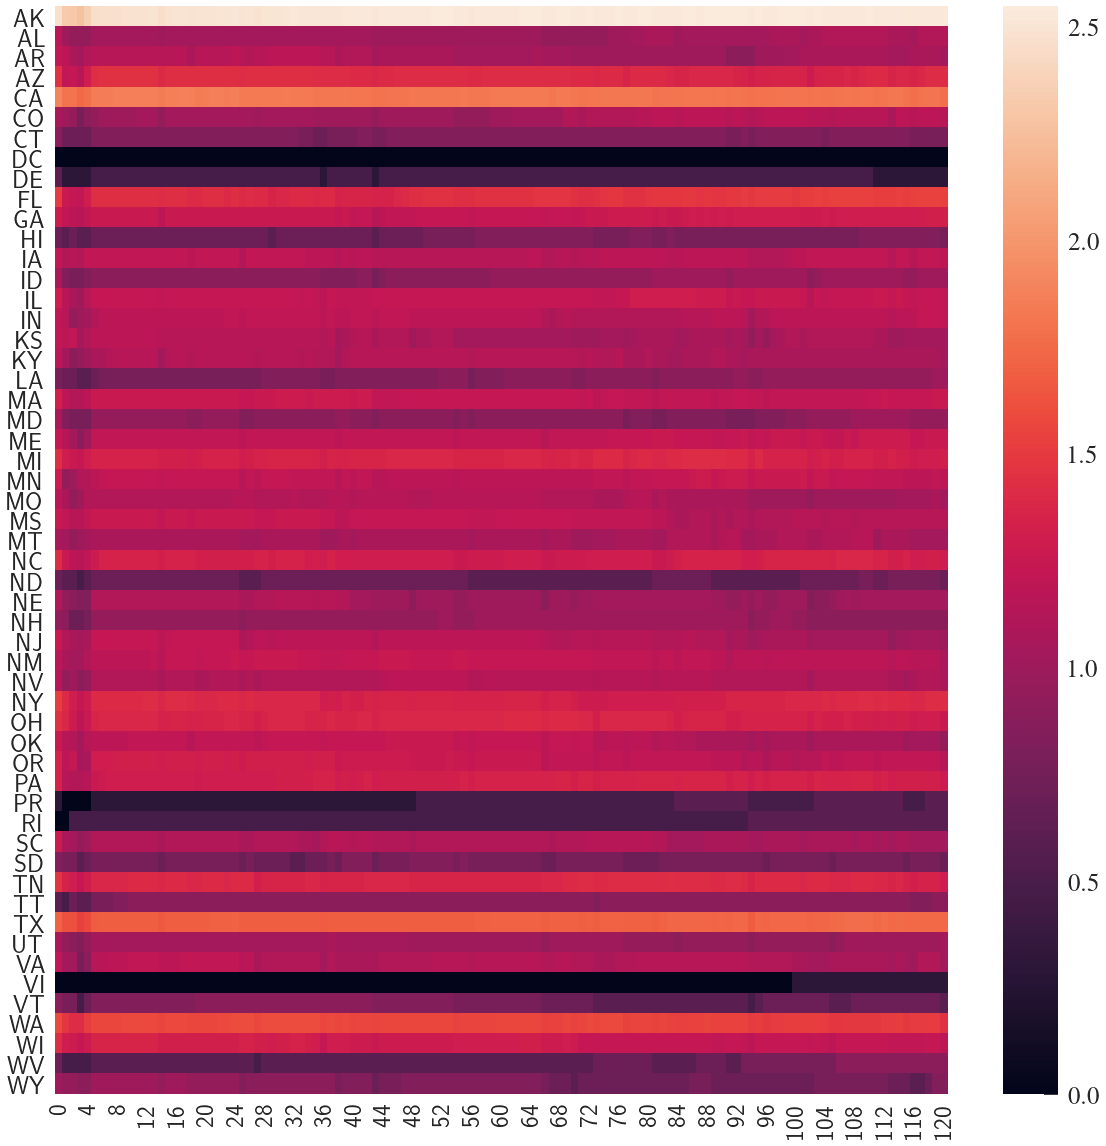

In [99]:
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(affect,ax=ax,yticklabels=states)
plt.show()

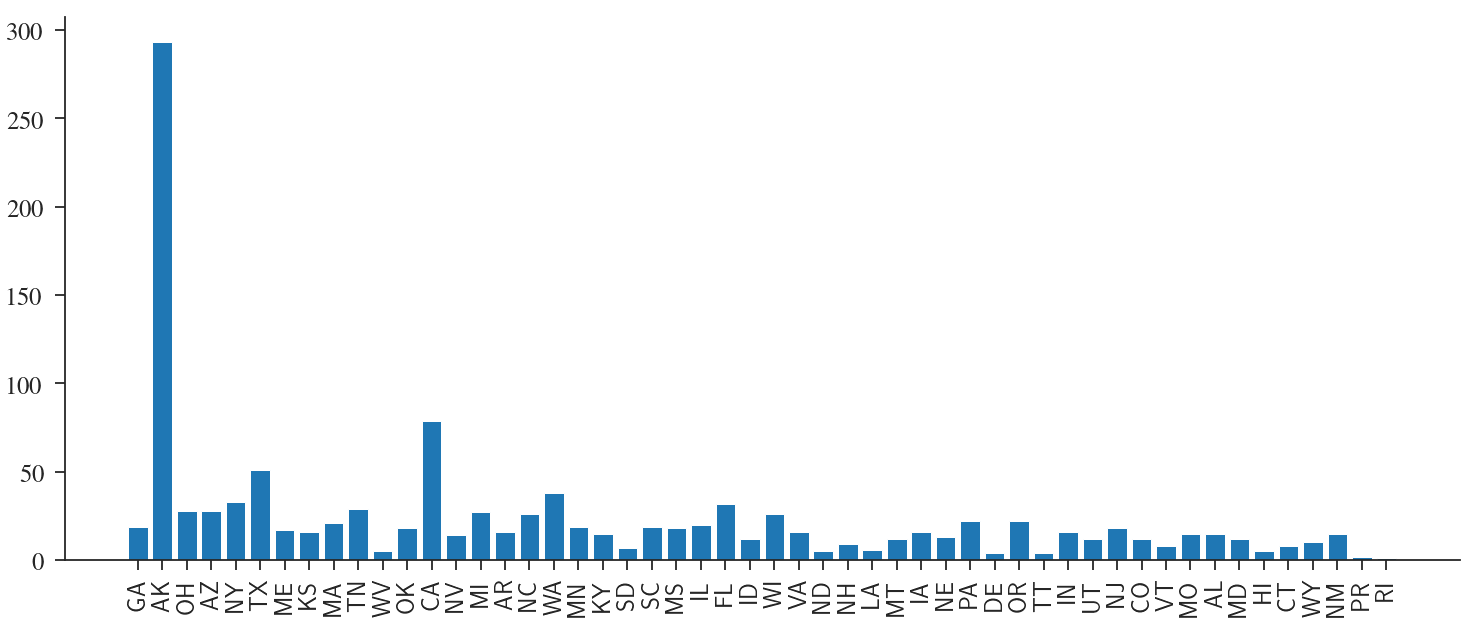

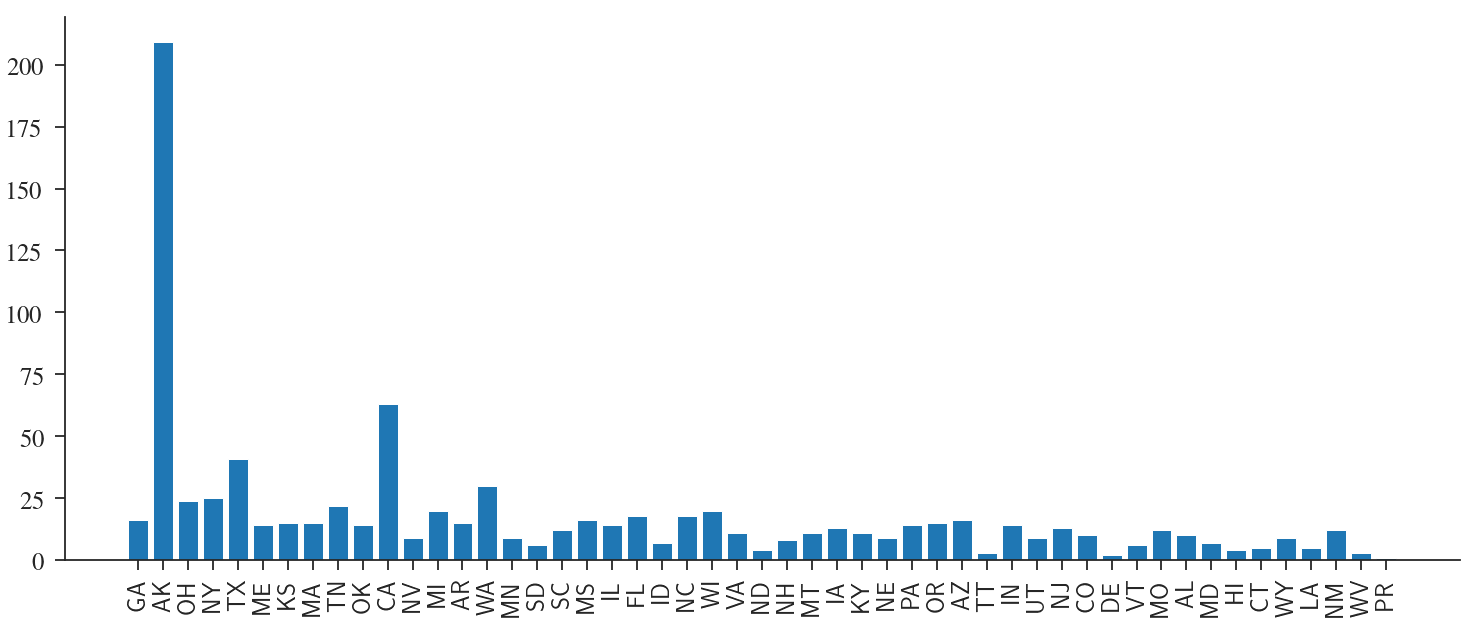

In [67]:
for D in affect_states[0:2]:
    fig,ax=plt.subplots(figsize=(25,10))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), list(D.keys()),rotation=90)
    custom_frame(ax)
    plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[nx.average_shortest_path_length(G) for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Nr',palette=colors,legend = 'full',data=data)
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
custom_frame(ax)
plt.show()